In [1]:
import numpy as np
import ConfigParser
from matplotlib import pyplot as plt
#Keras
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, Lambda, UpSampling2D, Deconvolution2D, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras import regularizers

#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import sys
sys.path.insert(0, './lib/')
# help_functions.py
from help_functions import *
# extract_patches.py
from extract_patches import *
from extract_patches import recompone
from extract_patches import recompone_overlap
from extract_patches import paint_border
from extract_patches import kill_border
from extract_patches import pred_only_FOV
from extract_patches import get_data_testing
from extract_patches import get_data_testing_overlap
# pre_processing.py
from help_functions import *
from pre_processing import *
from extract_patches import *
from mask_retina import *
from model import *
from dual_IDG import *

Using TensorFlow backend.


In [2]:
raw_train = load_hdf5("DISC/raw_train.hdf5")
raw_test =  load_hdf5("DISC/raw_test.hdf5")
mask_train = load_hdf5("DISC/mask_train.hdf5")
mask_test = load_hdf5("DISC/mask_test.hdf5")

In [3]:
#Experiment name
experiment= "DISC_segmentation_modifiedUnet"
name_experiment= "DISC_segmentation/" + experiment
#training settings
N_epochs = 150
batch_size = 1
patch_height = 40
patch_width = 40
N_subimgs = 74*4000
optimizer = "sgd"
learningrate = 0.01
inside_FOV = False
to_extract_patches = False
trim = True
augmentation = True

directory = name_experiment
if not os.path.exists(directory):
    os.makedirs(directory)

with open(name_experiment + "/configuration.txt",'w') as out:
    line0 = '[training settings]'
    line1 = 'N_epochs = ' + str(N_epochs)
    line2 = 'batch_size = ' + str(batch_size)
    line3 = 'patch_height = ' + str(patch_height)
    line4 = 'patch_width = ' + str(patch_width)
    line5 = 'N_subimgs = ' + str(N_subimgs)
    line6 = 'inside_FOV = ' + str(inside_FOV)
    line7 = 'optimizer = ' + optimizer
    line8 = 'learning rate = ' + str(learningrate)
    line9 = 'to_extract_patches = ' + str(to_extract_patches)
    line10 = 'trim = ' + str(trim)
    out.write('{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n'.format(line0,line1,line2,line3,line4,line5,line6, line7, line8, line9, line10)) 
    
    
    

In [4]:
def get_unet_loc2(n_ch, img_rows=480, img_cols=480):
    inputs = Input((n_ch, img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first', name = "conv1_1")(inputs)
    conv1 = BatchNormalization(axis=1, name = "conv1_2")(conv1)
    conv1 = Dropout(0.5, name = "conv1_3")(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first', name = "conv1_4")(conv1)
    conv1 = BatchNormalization(axis=1, name = "conv1_5")(conv1)
    pool1 = MaxPooling2D((2, 2), data_format='channels_first',name = "conv1_6")(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first', name = "conv2_1")(pool1)
    conv2 = BatchNormalization(axis=1, name = "conv2_2")(conv2)
    conv2 = Dropout(0.5, name = "conv2_3")(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv2_4")(conv2)
    conv2 = BatchNormalization(axis=1,name = "conv2_5")(conv2)
    pool2 = MaxPooling2D((2, 2), data_format='channels_first',name = "conv2_6")(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv3_1")(pool2)
    conv3 = BatchNormalization(axis=1,name = "conv3_2")(conv3)
    conv3 = Dropout(0.5,name = "conv3_3")(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv3_4")(conv3)
    conv3 = BatchNormalization(axis=1,name = "conv3_5")(conv3)
    pool3 = MaxPooling2D((2, 2), data_format='channels_first',name = "conv3_6")(conv3)
    
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv4_1")(pool3)
    conv4 = BatchNormalization(axis=1,name = "conv4_2")(conv4)
    conv4 = Dropout(0.5,name = "conv4_3")(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv4_4")(conv4)
    conv4 = BatchNormalization(axis=1,name = "conv4_5")(conv4)
    pool4 = MaxPooling2D((2, 2), data_format='channels_first',name = "conv4_6")(conv4)

    
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv5_1")(pool4)
    conv5 = BatchNormalization(axis=1,name = "conv5_2")(conv5)
    conv5 = Dropout(0.5,name = "conv5_3")(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv5_4")(conv5)
    conv5 = BatchNormalization(axis=1,name = "conv5_5")(conv5)
    
    conv6= Flatten()(conv5)
    conv6 = Dense(2,activation='relu',kernel_regularizer=regularizers.l2(0.001))(conv6)
    model = Model(input=inputs, output=conv6)
    
    model.compile(optimizer=SGD(lr=0.1, momentum=0.95),loss='mean_squared_error', metrics= ['mse'])
    
    return model



In [5]:
def get_center(mask):
    center = np.zeros((mask.shape[0],2))
    for i in range(mask.shape[0]):
        disc = np.where(mask[i] == 1)
        x = np.mean(disc[1])
        y = np.mean(disc[2])
        center[i] = [x,y]
    return center

In [6]:
def get_unet_seg2(n_ch, img_rows=480, img_cols=480):
    inputs = Input((n_ch, img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first', name = "conv1_1")(inputs)
    conv1 = BatchNormalization(axis=1, name = "conv1_2")(conv1)
    conv1 = Dropout(0.5, name = "conv1_3")(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first', name = "conv1_4")(conv1)
    conv1 = BatchNormalization(axis=1, name = "conv1_5")(conv1)
    conv1.trainable = False
    pool1 = MaxPooling2D((2, 2), data_format='channels_first',name = "conv1_6")(conv1)
    pool1.trainable = False
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first', name = "conv2_1")(pool1)
    conv2 = BatchNormalization(axis=1, name = "conv2_2")(conv2)
    conv2 = Dropout(0.5, name = "conv2_3")(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv2_4")(conv2)
    conv2 = BatchNormalization(axis=1,name = "conv2_5")(conv2)
    conv2.trainable = False
    pool2 = MaxPooling2D((2, 2), data_format='channels_first',name = "conv2_6")(conv2)
    pool2.trainable = False
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv3_1")(pool2)
    conv3 = BatchNormalization(axis=1,name = "conv3_2")(conv3)
    conv3 = Dropout(0.5,name = "conv3_3")(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv3_4")(conv3)
    conv3 = BatchNormalization(axis=1,name = "conv3_5")(conv3)
    conv3.trainable = False
    pool3 = MaxPooling2D((2, 2), data_format='channels_first',name = "conv3_6")(conv3)
    pool3.trainable = False
    
    
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv4_1")(pool3)
    conv4 = BatchNormalization(axis=1,name = "conv4_2")(conv4)
    conv4 = Dropout(0.5,name = "conv4_3")(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv4_4")(conv4)
    conv4 = BatchNormalization(axis=1,name = "conv4_5")(conv4)
    conv4.trainable = False
    pool4 = MaxPooling2D((2, 2), data_format='channels_first',name = "conv4_6")(conv4)
    pool4.trainable = False
    
    
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv5_1")(pool4)
    conv5 = BatchNormalization(axis=1,name = "conv5_2")(conv5)
    conv5 = Dropout(0.5,name = "conv5_3")(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first',name = "conv5_4")(conv5)
    conv5 = BatchNormalization(axis=1,name = "conv5_5")(conv5)
    conv5.trainable = False
    
    up1 = UpSampling2D(size=(2, 2), data_format='channels_first')(conv5)
    up1 = concatenate([conv4,up1],axis=1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv6 = BatchNormalization(axis=1)(conv6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv6)
    conv6 = BatchNormalization(axis=1)(conv6)

    up2 = UpSampling2D(size=(2, 2), data_format='channels_first')(conv6)
    up2 = concatenate([conv3,up2],axis=1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv7 = BatchNormalization(axis=1)(conv7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv7)
    conv7 = BatchNormalization(axis=1)(conv7)

    up3 = UpSampling2D(size=(2, 2), data_format='channels_first')(conv7)
    up3 = concatenate([conv2,up3],axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up3)
    conv8 = BatchNormalization(axis=1)(conv8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv8)
    conv8 = BatchNormalization(axis=1)(conv8)

    up4 = UpSampling2D(size=(2, 2), data_format='channels_first')(conv8)
    up4 = concatenate([conv1,up4],axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up4)
    conv9 = BatchNormalization(axis=1)(conv9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv9)
    conv9 = BatchNormalization(axis=1)(conv9)

    
    conv10 = Conv2D(1, (1, 1), activation='relu', padding='same',data_format='channels_first')(conv9)
    conv10 = BatchNormalization(axis=1)(conv10)
    ############
    conv10 = core.Activation('sigmoid')(conv10)

    model = Model(input=inputs, output=conv10)


    return model



In [16]:
checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/'+ experiment +'_best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decrease

sgd = SGD(lr=10e-6)
localizer.compile(loss='mean_squared_error', optimizer='rmsprop', metrics= ['mse'])
history = localizer.fit(my_PreProc(raw_train), center_train, nb_epoch=2, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpointer])

/home/sh402/retina-unet/rop_env_cpu/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 65 samples, validate on 8 samples
Epoch 1/2
64/65 [============================>.] - ETA: 16s - loss: 120.0379 - mean_squared_error: 119.7266
Epoch 00001: val_loss improved from inf to 670.70332, saving model to ./DISC_segmentation/DISC_segmentation_modifiedUnet/DISC_segmentation_modifiedUnet_best_weights.h5
65/65 [==============================] - 1162s 18s/step - loss: 119.6716 - mean_squared_error: 119.3603 - val_loss: 670.7033 - val_mean_squared_error: 670.3903
Epoch 2/2
64/65 [============================>.] - ETA: 18s - loss: 99.2625 - mean_squared_error: 98.9498
Epoch 00002: val_loss did not improve
65/65 [==============================] - 1260s 19s/step - loss: 98.1095 - mean_squared_error: 97.7969 - val_loss: 1452.3140 - val_mean_squared_error: 1452.0031


In [7]:
localizer = get_unet_loc2(1,480,480)
experiment = "Full_Localizer1"
localizer.load_weights("DISC_segmentation/" + experiment + "/" + experiment + "_best_weights.h5")
#localizer.load_weights("DISC_segmentation/Full_Localizer1/Full_Localizer1_best_weights.h5")
#pred_center = localizer.predict(raw_test, batch_size=32, verbose=2)

/home/sh402/retina-unet/rop_env_cpu/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [8]:
test_data = load_hdf5("DISC/total_raw.hdf5")
test_mask = load_hdf5("DISC/total_mask.hdf5")
test_data = test_data[:,:,:,80:560]
test_mask = test_mask[:,:,:,80:560]
    
print("preprocessing data ...")
test_data = my_PreProc(test_data)
test_mask = get_center(test_mask)

preprocessing data ...


In [9]:
pred_center = localizer.predict(test_data, batch_size=32, verbose=2)

In [25]:
raw_img = load_hdf5("DISC/total_raw.hdf5")
raw_img = raw_img[:,:,:,80:560]
raw_img = np.swapaxes(raw_img,1,3)

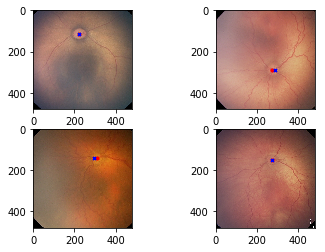

In [26]:
import matplotlib.pyplot as plt
from skimage.color import gray2rgb
t = np.swapaxes(test_data,1,3)
t = gray2rgb(t)
t.shape
n = 4

fig = plt.figure() 

for i in range(4):
    n = random.sample(range(92),1)[0]
    ax = fig.add_subplot(2,2, i+1)
    ax.imshow(raw_img[n]/255)
    ax.
    ax.scatter(test_mask[n][0],test_mask[n][1], s=10, c='red', marker='o')
    ax.scatter(pred_center[n][0],pred_center[n][1], s=10, c='blue', marker='x') 

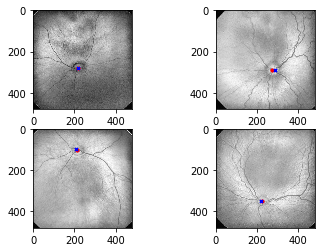

In [10]:
import matplotlib.pyplot as plt
from skimage.color import gray2rgb
t = np.swapaxes(test_data,1,3)
t = gray2rgb(t)
t.shape
n = 8

fig = plt.figure() 

for i in range(4):
    n = random.sample(range(92),1)[0]
    ax = fig.add_subplot(2,2, i+1)
    ax.imshow(np.squeeze(t[n]))
    ax.scatter(test_mask[n][0],test_mask[n][1], s=10, c='red', marker='o')
    ax.scatter(pred_center[n][0],pred_center[n][1], s=10, c='blue', marker='x') 


In [18]:
test_mask

array([[231.5746904 , 166.40712074],
       [246.8618052 , 123.95512494],
       [221.54487179, 133.49358974],
       [241.40817186, 172.30370682],
       [252.43130816, 305.53694581],
       [245.76536313, 178.91284916],
       [243.14099526, 116.28672986],
       [258.78334339, 119.55159928],
       [224.42245266, 332.42605951],
       [221.05804312, 121.08347153],
       [223.58319137, 145.47813742],
       [275.93676662, 286.53780965],
       [256.07246377, 284.53864734],
       [226.65333333, 116.64      ],
       [241.29260238, 305.94980185],
       [262.94503054, 337.11215991],
       [214.81266968, 157.67058824],
       [204.8428627 , 336.51886426],
       [245.62399356, 108.431562  ],
       [254.4546697 , 113.11890661],
       [234.33377483, 331.81589404],
       [199.97964544, 304.65988181],
       [221.02328831, 166.18723801],
       [207.56893543, 125.12827225],
       [258.69698911, 100.36002562],
       [263.3185654 , 321.30337553],
       [230.62228412, 310.35320334],
 

In [18]:
pred_center

array([[215.97964 , 166.69536 ],
       [253.2333  , 135.905   ],
       [208.4318  , 135.1699  ],
       [230.41486 , 189.35684 ],
       [261.25946 , 287.41022 ],
       [231.34935 , 183.6322  ],
       [241.64822 , 118.01287 ],
       [244.70044 , 130.2848  ],
       [209.19708 , 333.78302 ],
       [216.9403  , 120.35594 ],
       [223.15465 , 143.97609 ],
       [260.9638  , 294.52505 ],
       [245.77783 , 293.70142 ],
       [212.95694 , 121.798355],
       [241.98898 , 309.00916 ],
       [268.3888  , 336.9429  ],
       [220.88405 , 164.85832 ],
       [212.10823 , 316.60974 ],
       [247.31754 , 113.12031 ],
       [251.69814 , 130.07216 ],
       [230.8171  , 355.8545  ],
       [218.06372 , 305.02838 ],
       [221.92221 , 162.43987 ],
       [196.3388  , 126.40629 ],
       [227.62833 , 146.6414  ],
       [263.03217 , 328.61823 ],
       [224.60512 , 314.55792 ],
       [197.15086 ,  98.580666],
       [286.29755 , 347.28333 ],
       [221.19604 , 291.7531  ],
       [19

In [19]:
from sklearn.metrics import mean_squared_error
mean_squared_error(pred_center, test_mask)

206.1550280493252

In [29]:
mask_center

array([[257.92172, 148.70528],
       [248.31989, 154.21877],
       [266.14832, 274.18338],
       [250.52837, 162.82237],
       [246.56999, 167.29865],
       [247.43767, 283.8125 ],
       [245.53804, 128.5603 ],
       [249.72414, 180.33551],
       [255.09279, 218.58092],
       [243.60712, 270.0937 ],
       [247.47798, 334.73166],
       [221.50636, 150.97977],
       [263.53134, 328.3518 ],
       [245.60526, 170.77928],
       [257.68918, 158.57472],
       [256.44208, 287.30978],
       [240.2431 , 323.0687 ],
       [273.9627 , 302.57468],
       [255.99988, 297.336  ]], dtype=float32)

In [30]:
mask_center

array([[238.77533265, 138.65864893],
       [249.05691057, 160.98025552],
       [221.09123649, 285.80472189],
       [269.29147342, 116.82946843],
       [309.09230769, 139.12360743],
       [252.43130816, 305.53694581],
       [264.64434463, 135.08819927],
       [264.32629108, 153.78920188],
       [286.62099125, 172.87113703],
       [274.43532172, 286.96514745],
       [228.25075347, 332.49276673],
       [236.78206945, 130.43338058],
       [224.42245266, 332.42605951],
       [298.96267109, 125.20945666],
       [305.33333333,  73.04310777],
       [248.26956522, 292.15120773],
       [287.56274769, 347.43769265],
       [288.99125205, 337.07873155],
       [255.00980392, 293.84416925]])

# Train Segmenter

In [14]:
#Train parameters
experiment= "Segmenter4"
name_experiment= "DISC_segmentation/" + experiment
localizer_weight = "LocUnet_name2"
#training settings
N_epochs = 500
batch_size = 8
patch_height = 480
patch_width = 480
N_subimgs = 73*6*1000
optimizer = "sgd"
learningrate = 0.01
inside_FOV = False
to_extract_patches = False
trim = True
augmentation = True

In [15]:
raw_img = load_hdf5("DISC/total_raw.hdf5")
mask_img = load_hdf5("DISC/total_mask.hdf5")

raw_train, raw_test, mask_train, mask_test = train_test_split(raw_img, mask_img, test_size = 0.2, random_state = 123)

if trim == True:
    raw_train_trimmed = raw_train[:,:,:,80:560]
    mask_train_trimmed = mask_train[:,:,:,80:560]
    
print("preprocessing data ...")
raw_train_processed = my_PreProc(raw_train_trimmed)


if augmentation == True:
    train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0)
    print("Images augmentation ...")
    raw_train_aug = raw_train_trimmed
    mask_train_aug = mask_train_trimmed
    for i in range(5):
        x = raw_train_trimmed.swapaxes(1,3)
        y = mask_train_trimmed.swapaxes(1,3)
        new_x, new_y = train_idg.flow(x, y, batch_size=74, shuffle=True).next()
    
        new_x = new_x.swapaxes(1,3)
        new_y = new_y.swapaxes(1,3)
    
        raw_train_aug = np.concatenate((raw_train_aug, new_x), axis = 0)
        mask_train_aug = np.concatenate((mask_train_aug, new_y), axis = 0)
        
    raw_train_processed = my_PreProc(raw_train_aug)
    mask_train = mask_train_aug

    print("Finish augmentation !")
else:
    mask_train = mask_train_trimmed
    

print("raw train processed shape:" +  str(raw_train_processed.shape))
print("mask train shape:" + str(mask_train.shape))


print("Extracting data ...")
if to_extract_patches == True:
    patches_imgs_train, patches_masks_train = extract_random_with_disc(raw_train_processed,
                                                                   mask_train,
                                                                   patch_height,
                                                                   patch_width,
                                                                   N_subimgs,
                                                                   inside_FOV)
else:
    patches_imgs_train = raw_train_processed
    patches_masks_train = mask_train
    
    
print("Finish extracting !")

preprocessing data ...
Images augmentation ...
Finish augmentation !
raw train processed shape:(438, 1, 480, 480)
mask train shape:(438, 1, 480, 480)
Extracting data ...
Finish extracting !


In [19]:
segmenter = get_unet_seg2(1,480,480)
segmenter.load_weights("DISC_segmentation/LocUnet_name2/LocUnet_name2_best_weights.h5", by_name=True)
segmenter.compile(optimizer='sgd', loss=log_dice_loss ,metrics=['accuracy', mean_IOU_gpu, dice_metric])

print "Check: final output of the network:"
print segmenter.output_shape
checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/'+ experiment +'_best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decrease

#patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption


/home/sh402/retina-unet/rop_env_cpu/lib/python2.7/site-packages/ipykernel_launcher.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


Check: final output of the network:
(None, 1, 480, 480)


In [17]:
patches_masks_train.shape

(438, 1, 480, 480)

In [14]:
raw_img = load_hdf5("DISC/total_raw.hdf5")
mask_img = load_hdf5("DISC/total_mask.hdf5")

raw_train, raw_test, mask_train, mask_test = train_test_split(raw_img, mask_img, test_size = 0.2, random_state = 123)

In [22]:
raw_train.shape

(73, 3, 480, 640)

In [25]:
t = raw_train[0:int(raw_train.shape[0]*0.8),:,:,:]

In [26]:
t.shape

(58, 3, 480, 640)

In [21]:
int(raw_train.shape[0]*0.8)

58

In [27]:
import random

In [35]:
t = random.sample(range(raw_train.shape[0]), int(raw_train.shape[0]*0.8))

In [40]:
raw_train[t].shape

(58, 3, 480, 640)